#                                            Assignment 1: Deep Learning
## By Saumya Rawat
## CMSC 828L: Deep Learning

                                                    
                                                    



In [1]:
# Python imports

# The code uses Numpy to perform all necessary mathematical computations and matplotlib for all illustrations 

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#from mpl_toolkits.mplot3d import axes3d

np.random.seed(seed=1)



## General Neural Network Class

In [2]:
def softmax(A):
    expA = np.exp(A)
    return expA / expA.sum(axis=1, keepdims=True)

def activation(x, function):
    if function is 'sigmoid':
        ''' Sigmoid like function using tanh '''
        return np.tanh(x)
    elif function is 'relu':
        #return np.maximum(0,x)
        x[x<=0]=0.01*x[x<=0] # Using leaky relu
        return x

def derivative_activation(x, function):
    if function is 'sigmoid':
        return 1.0-x**2
    elif function is 'relu':
        #x[x<=0] = 0
        #x[x>0] = 1
        #return x
        alpha = 0.01
        dx = np.ones_like(x)
        dx[x < 0] = alpha
        return dx

class NeuralNetwork:
    def __init__(self, n_input=None, n_output=None, n_hidden_nodes=None, depth=None, nn_type='regression'):
        self.n_input = n_input  # Dimension of input
        self.n_output = n_output  # number of classes
        self.n_hidden_nodes = n_hidden_nodes  # number of hidden nodes/layers
        self.depth = 1 
        self.layers = []       
        self.layers.append(np.ones(n_input+1))# +1 for bias
        self.weights = []
          
        # Add empty hidden layers, one output layer
        for i in range(self.depth):
            self.layers.append(np.ones(n_hidden_nodes))
        self.layers.append(np.ones(n_output))
        
        
        
        # Parameters
        # Weight matrix
        for i in range((self.depth+2)-1):
            self.weights.append(np.zeros((self.layers[i].size, self.layers[i+1].size)))

        # last change in weights (for momentum)
        self.dw = [0,]*len(self.weights)

        # delta W
        #self.dw = [0,]* len(self.weights)
        self.dw = list(np.zeros(len(self.weights)))
        self.reset()
        
        
    def reset(self):
        for i in range(len(self.weights)):
            Z = np.random.random((self.layers[i].size,self.layers[i+1].size))
            self.weights[i][...] = (2*Z-1)*0.25

    def _forward_pass(self, x_i, function):
        self.layers[0][0:-1] = x_i
        for i in range(1,self.depth+2):
            self.layers[i][...] = activation(np.dot(self.layers[i-1],self.weights[i-1]),function)
        return(self.layers[-1])
    
            
    def _train_model(self,X_train, y_train, eta, epochs, momentum, function):
        loss = []
        for t in range(epochs):
            for j in range(len(X_train)):
                
                # forward pass
                self._forward_pass(X_train[j], function)
                
                
                # backward pass
                deltas = []

                # error at output layer
                error = y_train[j] - self.layers[-1]
                delta = error * derivative_activation(self.layers[-1],function)
                deltas.append(delta)
                
                # error at hidden layers
                for i in range(self.depth,0,-1):
                    delta = np.dot(deltas[0],self.weights[i].T)*derivative_activation(self.layers[i],function)
                    deltas.insert(0,delta)
                    
                # weight updates
                for i in range(len(self.weights)):
                    layer = np.atleast_2d(self.layers[i])
                    delta = np.atleast_2d(deltas[i])
                    dw = np.dot(layer.T,delta)
                    self.weights[i] += eta*dw + momentum*self.dw[i]
                    self.dw[i] = dw
                loss.append((error**2).sum())
                    
                
def deep_network( X, x, eta, epochs, momentum, n_input=None, n_output=None, n_hidden_nodes=None, depth=None, function='sigmoid', nn_type='regression'):
    network = NeuralNetwork( n_input, n_output, n_hidden_nodes, depth, nn_type )
    
    # Train network
    network._train_model(x,X,eta,epochs,momentum,function)
    return network


In [3]:
def create_data(dim,length,question_no):
    if question_no == 1:
        #a = numpy.zeros(shape=(1,length))
        # input samples (uniform distribution [0,1])
        x = np.random.uniform(0, 1, length)
        fx = 3*x #f = 3x
        mu, sigma = 0, 0.2 # mean and standard deviation
        G = np.random.normal(mu, sigma, length)
        X = fx + G #f = 3x+Gaussian noise
        return(X,x)

    elif question_no == 2:
        x = np.linspace(0,1,length)
        X = np.sin(x*np.pi)
        return(X,x)
        

## 1. 
This network contains an input layer and an output layer, with no nonlinearities. Graphically it can be represented as: 
![alt text](image1.png "Simple Linear Regression")

The network approximates a target $t$ with the weights that it computes by using squared error cost function. 


In the given example, input is generated by a function $f$ defined as $f(x)=3*x$ with an additive gaussian noise sampled from  $\mathcal{N}(\mu = 0,\,\sigma=0.1)$

The number of samples, given by `length` is 30

The goal of the network is to optimize the model $y=x*w$ by modifying the weights ($w$).  Hence the cost function is defined as $\sum_{i=1}^N || t_i - y_i ||^2$. The cost function is optimized using Gradient Descent.


The two figures, depicting the input as well as the line fitted by the model are illustrated below.



In [4]:
def gradient(w, x, t): 
    return 2 * x * (x*w - t)

def delta_w(w_k, x, t, learning_rate):
    return learning_rate * gradient(w_k, x, t).sum()

def linear_regression_ann(X,x): 
    # Plot the initial input data
    plt.plot(x, X, 'x', label='Target')
    plt.plot([0, 1], [3*0, 3*1], 'r-', label='f(x)=3*x+$\Xi$')
    plt.xlabel('$x$', fontsize=15)
    plt.ylabel('$t$', fontsize=15)
    plt.ylim([0,3])
    plt.title('x vs t graph')
    plt.grid()
    plt.legend(loc=2)
    plt.show()

    # Parameters
    # initial weight parameter
    w = 0.1
   
    # learning rate, number of epochs
    eta = 0.1
    epochs = 100
    w_cost = [(w, ((X-(x*w))**2).sum())]
    
    #Begin training
    for i in range(epochs):
        dw = delta_w(w, x, X, eta)  # Get the delta w update
        w = w - dw  # Update the current weight parameter
        w_cost.append((w, ((X-(x*w))**2).sum()))  # Add weight,cost to list

    # Plot the fitted line versus the original input
    plt.plot(x, X, 'x', label='Target')
    # f(x)
    plt.plot([0, 1], [3*0, 3*1], 'g-', label='f(x)=3*x+$\Xi$')
    # fitted line
    plt.plot([0, 1], [0*w, 1*w], 'r-', label='fitted line')
    plt.xlabel('input x')
    plt.ylabel('target X')
    plt.ylim([0,3])
    plt.title('input vs. target')
    plt.grid()
    plt.legend(loc=2)
    plt.show()


### (a) Testing with 1D data


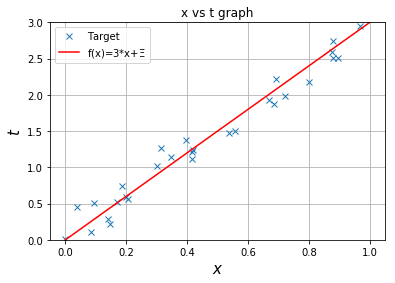

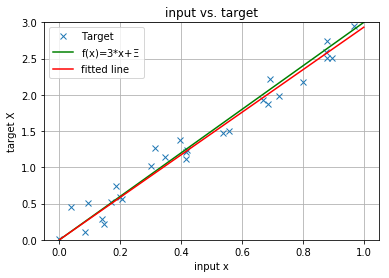

In [5]:
# Generate input as f(x)+G
# no of samples
length = 30
x = np.random.uniform(0, 1, length)

fx = 3*x #f = 3x
mu, sigma = 0, 0.2 # mean and standard deviation
G = np.random.normal(mu, sigma, length)
X = fx + G #f = 3x+Gaussian noise



# Train the network with generated inputs
linear_regression_ann(X,x)

### (b) Testing with higher dimensional input with held out test data
$f(x,y) = \exp^{-x^2}sin(y)$ 


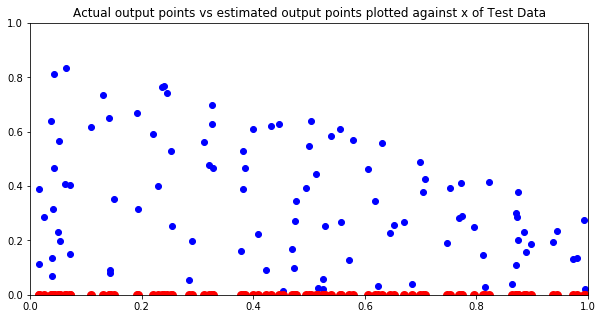

Perfomance of network measured by accuracy is  74.0  %.


In [6]:
# Running the general network code written for subsequent parts for higher dimensions, no of hidden layers specified as 0

x,y = np.mgrid[-2:2:20j, 0:(2*np.pi):20j]
f = np.exp(-x**2)*np.sin(y)

function = 'relu'
nn_type = 'regression'
# Paramaters

# Learning rate
eta = 0.01

# No of iterations of gradient descent
epochs = 200

# Input dimension
n_input = 2

# Output dimension
n_output = 1

# No of hidden layers
depth = 0

# No of units in hidden layers
n_hidden_nodes = 0

# Generate a random dataset to test the neural network
no_of_samples = 500
split = 400
dim = n_input
rand_x = np.random.rand(no_of_samples,dim)
rand_x_train, rand_x_test = rand_x[:split,:], rand_x[split:,:]
x_train,y_train = np.array([i[0] for i in rand_x_train]),np.array([i[1] for i in rand_x_train])
x_test,y_test = np.array([i[0] for i in rand_x_test]),np.array([i[1] for i in rand_x_test])
f_train = np.exp(-x_train**2)*np.sin(y_train)
f_test = np.exp(-x_test**2)*np.sin(y_test)

network = deep_network(f_train, rand_x_train, eta, epochs, 0.1, n_input, n_output, n_hidden_nodes, depth, function, nn_type)

acc = 0
predicted = []

# Plot data
plt.figure(figsize=(10,5))
plt.scatter(x_test,f_test,color='b',lw=1)
for i in range(len(x_test)):
    predicted.extend(network._forward_pass(rand_x_test[i], function))
    if round(f_test[i]) == round(predicted[i]):
        acc+=1
plt.scatter(x_test,predicted,color='r',lw=3)

plt.axis([0,1,0,1])
plt.title('Actual output points vs estimated output points plotted against x of Test Data')
plt.show()

print("Perfomance of network measured by accuracy is ",(acc/len(predicted))*100," %.")



### (c). 
Since the network has a simple set of hyperparameters and no non linearity, hyperparameters can be easily evaluated.

## 2. 
Now the network is a fully connected neural network with a single hidden layer, and a ReLU nonlinearity. The number of units in the hidden layer is specified with `n_hidden_nodes` and the size of input with `n_input`. Graphically it can be represented as: 
![alt text](image2.png "Simple 3-layer Neural Network")

The network approximates a target $t$ with the weights that are computed using backpropagation. 

In the given example, input is a sine wave and the two figures below depict the input and the function fitted by the network. 

The network is still trained using regression loss.

### (a).


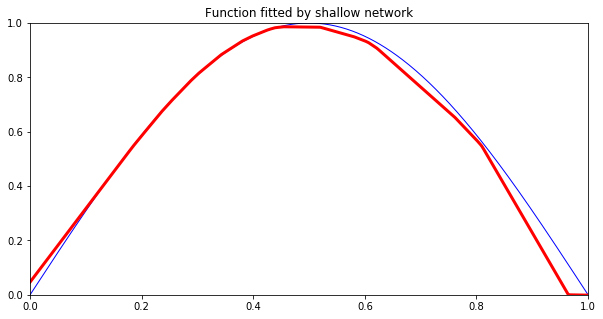

In [7]:
# Running the general network code written for subsequent parts for higher dimensions, no of hidden layers specified as 0

nn_type = 'regression'
# Activation function
function = 'relu'
# Momentum
momentum = 0.1

# Paramaters
# Learning rate
eta = 0.01

# No of epochs for training
epochs = 200

# Input dimention
n_input = 1

# Output dimension
n_output = 1

# No of hidden layers
depth = 1

# No of units in hidden layers
n_hidden_nodes = 200

# Generate a random dataset to test the neural network
no_of_samples = 500
x = np.linspace(0,1,no_of_samples)
y = np.sin(x*np.pi)

# Train the network
network = deep_network(y, x, eta, epochs, momentum, n_input, n_output, n_hidden_nodes, depth, function, nn_type)

# Plot data
computed = []
plt.figure(figsize=(10,5))
plt.plot(x,y,color='b',lw=1, label = 'Original')
for i in range(no_of_samples):
    computed.extend(network._forward_pass(x[i], function))
plt.plot(x,computed,color='r',lw=3, label ='Computed by network')
plt.axis([0,1,0,1])
plt.title('Function fitted by shallow network')
plt.show()



### (b) Testing with higher dimensional input with held out test data

$f(x,y) = \exp^{-x^2}sin(y)$ 


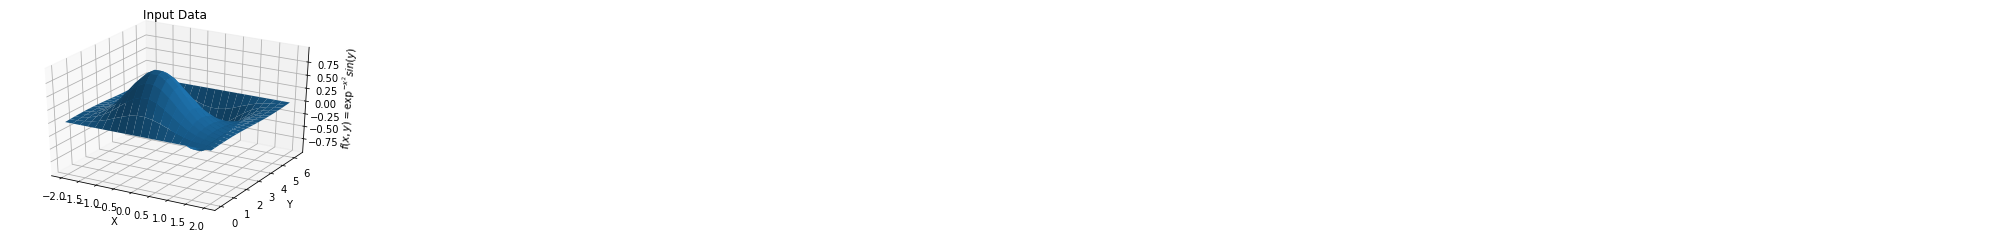

Perfomance of network measured by accuracy is  100.0  %.


In [8]:
# Generate a random dataset to test the neural network
no_of_samples = 20
split = 14
X,Y = np.mgrid[-2:2:20j, 0:(2*np.pi):20j]
output_f = np.exp(-X**2)*np.sin(Y)

rand_x = []
rand_x_train = []
rand_x_test = []
for i in range(split):
    rand_x_train.extend([list(a) for a in zip(X[i],Y[i])])

for i in range(split,len(X)):
    rand_x_test.extend([list(a) for a in zip(X[i],Y[i])])
    
function = 'relu'
nn_type = 'regression'
# Paramaters

# Learning rate
eta = 0.01

# No of iterations of gradient descent
epochs = 200

# Input dimension
n_input = 2

# Output dimension
n_output = 1

# No of hidden layers
depth = 0

# No of units in hidden layers
n_hidden_nodes = 0

x_train,y_train = np.array([i[0] for i in rand_x_train]),np.array([i[1] for i in rand_x_train])

x_test,y_test = np.array([i[0] for i in rand_x_test]),np.array([i[1] for i in rand_x_test])
f_train = np.exp(-x_train**2)*np.sin(y_train)
f_test = np.exp(-x_test**2)*np.sin(y_test)

network = deep_network(f_train, rand_x_train, eta, epochs, 0.1, n_input, n_output, n_hidden_nodes, depth, function, nn_type)


# Plot data
x = np.reshape(X, (len(np.unique(X)), len(np.unique(Y))))
y = np.reshape(Y, (len(np.unique(X)), len(np.unique(Y))))
z = np.reshape(output_f, (len(np.unique(X)), len(np.unique(Y))))
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(x, y, z)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('$f(x,y) = \exp^{-x^2}sin(y)$ ')
plt.title('Input Data')

plt.show()

acc = 0
predicted = []
for i in range(len(x_test)):
    predicted.extend(network._forward_pass(rand_x_test[i], function))    
    if round(f_test[i]) == round(predicted[i]):
        acc+=1
print("Perfomance of network measured by accuracy is ",(acc/len(predicted))*100," %.")


### (c).
For the 1D case, the network contains one one input unit while for larger dimensions the number of weights involved increases making it difficult to find an appropriate set of hyperparameters as well as increasing the complexity for visualing the results.

### 3.  
We now upgrade our deep network implementation with arbitary depth support and relu activation. 

### (a).  

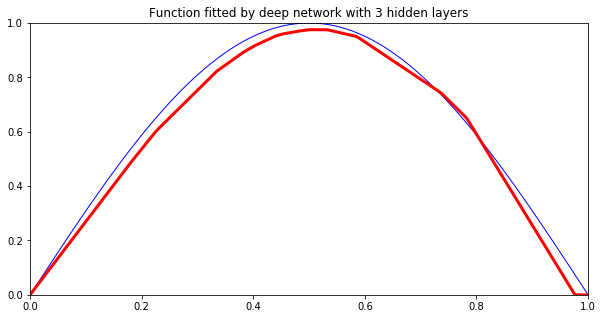

In [9]:
# Running the general network code written for subsequent parts for higher dimensions, no of hidden layers specified as 0

nn_type = 'regression'
# Activation function
function = 'relu'
# Momentum
momentum = 0.1

# Paramaters
# Learning rate
eta = 0.01

# No of epochs for training
epochs = 200

# Input dimention
n_input = 1

# Output dimension
n_output = 1

# No of hidden layers
depth = 3

# No of units in hidden layers
n_hidden_nodes = 200

# Generate a random dataset to test the neural network
no_of_samples = 500
x = np.linspace(0,1,no_of_samples)
y = np.sin(x*np.pi)

# Train the network
network = deep_network(y, x, 0.01, 200, 0.1, n_input, n_output,100, depth, function, nn_type)


# Plot data
computed = []
plt.figure(figsize=(10,5))
plt.plot(x,y,color='b',lw=1, label = 'Original')
for i in range(no_of_samples):
    computed.extend(network._forward_pass(x[i], function))
plt.plot(x,computed,color='r',lw=3, label ='Computed by network')
plt.axis([0,1,0,1])
plt.title('Function fitted by deep network with 3 hidden layers')

plt.show()


Text(0.5, 1.0, 'Function fitted by deep network with 5 hidden layers')

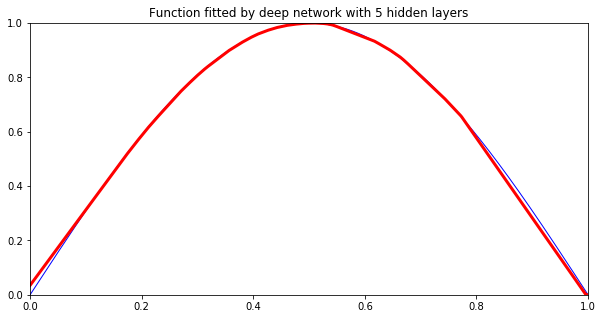

In [10]:

# Train the network
network_5 = deep_network(y, x, 0.01, 200, 0.1, n_input, n_output,200, depth, function, nn_type)

# Plot data
computed = []
plt.figure(figsize=(10,5))
plt.plot(x,y,color='b',lw=1, label = 'Original')
for i in range(no_of_samples):
    computed.extend(network_5._forward_pass(x[i], function))
plt.plot(x,computed,color='r',lw=3, label ='Computed by network')
plt.axis([0,1,0,1])
plt.title('Function fitted by deep network with 5 hidden layers')




### (b). 
Choosing hyperparameters for deep networks is harder as different layers in the deep network learn at  different speeds. Which means that early layers can get stuck and the laters layers are learning well. Deeper networks can lead to vanishing gradient problem as well. In my case, I found using a leaky relu instead of traditional relu improved my results.

### (c). 
Convergence is typically linked to learning rate and the number of hidden layers doesnt have a serious impact on the convergence speed.
